# Sentiment with Deep Neural Networks

### Import libraries and try out Trax

In [2]:
import os 
import shutil
import random as rnd

# import relevant libraries
import trax
import trax.fastmath.numpy as np
from trax import layers as tl
from trax import fastmath

In [3]:
# import Layer from the utils.py file
from utils import Layer, load_tweets, process_tweet

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Loading in the data

In [4]:
def train_val_split():
    # Load positive and negative tweets
    all_positive_tweets, all_negative_tweets = load_tweets()

    # View the total number of positive and negative tweets.
    print(f"The number of positive tweets: {len(all_positive_tweets)}")
    print(f"The number of negative tweets: {len(all_negative_tweets)}")

    # Split positive set into validation and training
    val_pos   = all_positive_tweets[4000:] # generating validation set for positive tweets
    train_pos  = all_positive_tweets[:4000]# generating training set for positive tweets

    # Split negative set into validation and training
    val_neg   = all_negative_tweets[4000:] # generating validation set for negative tweets
    train_neg  = all_negative_tweets[:4000] # generating training set for nagative tweets
    
    # Combine training data into one set
    train_x = train_pos + train_neg 

    # Combine validation data into one set
    val_x  = val_pos + val_neg

    # Set the labels for the training set (1 for positive, 0 for negative)
    train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))

    # Set the labels for the validation set (1 for positive, 0 for negative)
    val_y  = np.append(np.ones(len(val_pos)), np.zeros(len(val_neg)))


    return train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y

In [5]:
train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y = train_val_split()

print(f"length of train_x {len(train_x)}")
print(f"length of val_x {len(val_x)}")

The number of positive tweets: 5000
The number of negative tweets: 5000
length of train_x 8000
length of val_x 2000


In [6]:
# Try out function that processes tweets
print("original tweet at training position 0")
print(train_pos[0])

print("Tweet at training position 0 after processing:")
process_tweet(train_pos[0])

original tweet at training position 0
#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Tweet at training position 0 after processing:


['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']

### Building the vocabulary

In [7]:
def get_vocab(train_x):

    # Include special tokens 
    # started with pad, end of line and unk tokens
    Vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2} 

    # Note that we build vocab using training data
    for tweet in train_x: 
        processed_tweet = process_tweet(tweet)
        for word in processed_tweet:
            if word not in Vocab: 
                Vocab[word] = len(Vocab)
    
    return Vocab

Vocab = get_vocab(train_x)

print("Total words in vocab are",len(Vocab))
display(Vocab)

Total words in vocab are 9089


{'__PAD__': 0,
 '__</e>__': 1,
 '__UNK__': 2,
 'followfriday': 3,
 'top': 4,
 'engag': 5,
 'member': 6,
 'commun': 7,
 'week': 8,
 ':)': 9,
 'hey': 10,
 'jame': 11,
 'odd': 12,
 ':/': 13,
 'pleas': 14,
 'call': 15,
 'contact': 16,
 'centr': 17,
 '02392441234': 18,
 'abl': 19,
 'assist': 20,
 'mani': 21,
 'thank': 22,
 'listen': 23,
 'last': 24,
 'night': 25,
 'bleed': 26,
 'amaz': 27,
 'track': 28,
 'scotland': 29,
 'congrat': 30,
 'yeaaah': 31,
 'yipppi': 32,
 'accnt': 33,
 'verifi': 34,
 'rqst': 35,
 'succeed': 36,
 'got': 37,
 'blue': 38,
 'tick': 39,
 'mark': 40,
 'fb': 41,
 'profil': 42,
 '15': 43,
 'day': 44,
 'one': 45,
 'irresist': 46,
 'flipkartfashionfriday': 47,
 'like': 48,
 'keep': 49,
 'love': 50,
 'custom': 51,
 'wait': 52,
 'long': 53,
 'hope': 54,
 'enjoy': 55,
 'happi': 56,
 'friday': 57,
 'lwwf': 58,
 'second': 59,
 'thought': 60,
 '’': 61,
 'enough': 62,
 'time': 63,
 'dd': 64,
 'new': 65,
 'short': 66,
 'enter': 67,
 'system': 68,
 'sheep': 69,
 'must': 70,
 'buy':

In [8]:
def tweet_to_tensor(tweet, vocab_dict, unk_token='__UNK__', verbose=False):
    '''
    Input: 
        tweet - A string containing a tweet
        vocab_dict - The words dictionary
        unk_token - The special string for unknown tokens
        verbose - Print info durign runtime
    Output:
        tensor_l - A python list with
        
    '''     
    # Process the tweet into a list of words
    # where only important words are kept (stop words removed)
    word_l = process_tweet(tweet)
    
    if verbose:
        print("List of words from the processed tweet:")
        print(word_l)
        
    # Initialize the list that will contain the unique integer IDs of each word
    tensor_l = [] 
    
    # Get the unique integer ID of the __UNK__ token
    unk_ID = vocab_dict[unk_token]
    
    if verbose:
        print(f"The unique integer ID for the unk_token is {unk_ID}")
        
    # for each word in the list:
    for word in word_l:
        
        # Get the unique integer ID.
        # If the word doesn't exist in the vocab dictionary,
        # use the unique ID for __UNK__ instead.        
        word_ID = vocab_dict[word] if word in vocab_dict else unk_ID
            
        # Append the unique integer ID to the tensor list.
        tensor_l.append(word_ID)
    
    return tensor_l

In [9]:
print("Actual tweet is\n", val_pos[0])
print("\nTensor of tweet:\n", tweet_to_tensor(val_pos[0], vocab_dict=Vocab))

Actual tweet is
 Bro:U wan cut hair anot,ur hair long Liao bo
Me:since ord liao,take it easy lor treat as save $ leave it longer :)
Bro:LOL Sibei xialan

Tensor of tweet:
 [1064, 136, 478, 2351, 744, 8149, 1122, 744, 53, 2, 2671, 790, 2, 2, 348, 600, 2, 3488, 1016, 596, 4558, 9, 1064, 157, 2, 2]


In [10]:
def data_generator(data_pos, data_neg, batch_size, loop, vocab_dict, shuffle=False):
    '''
    Input: 
        data_pos - Set of positive examples
        data_neg - Set of negative examples
        batch_size - number of samples per batch. Must be even
        loop - True or False
        vocab_dict - The words dictionary
        shuffle - Shuffle the data order
    Yield:
        inputs - Subset of positive and negative examples
        targets - The corresponding labels for the subset
        example_weights - An array specifying the importance of each example
        
    '''     

    # make sure the batch size is an even number
    # to allow an equal number of positive and negative samples    
    assert batch_size % 2 == 0
    
    # Number of positive examples in each batch is half of the batch size
    # same with number of negative examples in each batch
    n_to_take = batch_size // 2
    
    # Use pos_index to walk through the data_pos array
    # same with neg_index and data_neg
    pos_index = 0
    neg_index = 0
    
    len_data_pos = len(data_pos)
    len_data_neg = len(data_neg)
    
    # Get and array with the data indexes
    pos_index_lines = list(range(len_data_pos))
    neg_index_lines = list(range(len_data_neg))
    
    # shuffle lines if shuffle is set to True
    if shuffle:
        rnd.shuffle(pos_index_lines)
        rnd.shuffle(neg_index_lines)
        
    stop = False
    
    # Loop indefinitely
    while not stop:  
        
        # create a batch with positive and negative examples
        batch = []
        
        # First part: Pack n_to_take positive examples
        
        # Start from 0 and increment i up to n_to_take
        for i in range(n_to_take):
                    
            # If the positive index goes past the positive dataset,
            if pos_index >= len_data_pos: 
                
                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;
                # If user wants to keep re-using the data, reset the index
                pos_index = 0
                if shuffle:
                    # Shuffle the index of the positive sample
                    rnd.shuffle(pos_index_lines)
                    
            # get the tweet as pos_index
            tweet = data_pos[pos_index_lines[pos_index]]
            
            # convert the tweet into tensors of integers representing the processed words
            tensor = tweet_to_tensor(tweet, vocab_dict)
            
            # append the tensor to the batch list
            batch.append(tensor)
            
            # Increment pos_index by one
            pos_index = pos_index + 1


            
        ### START CODE HERE (Replace instances of 'None' with your code) ###

        # Second part: Pack n_to_take negative examples

        # Using the same batch list, start from 0 and increment i up to n_to_take
        for i in range(n_to_take):
            
            # If the negative index goes past the negative dataset,
            if pos_index>=len_data_pos:
                
                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True 
                    break 
                    
                # If user wants to keep re-using the data, reset the index
                neg_index = 0
                
                if shuffle:
                    # Shuffle the index of the negative sample
                    rnd.shuffle(neg_index_lines)
                    
            # get the tweet as neg_index
            tweet = data_neg[neg_index_lines[neg_index]]
            
            # convert the tweet into tensors of integers representing the processed words
            tensor = tweet_to_tensor(tweet,vocab_dict)
            
            # append the tensor to the batch list
            batch.append(tensor)
            
            # Increment neg_index by one
            neg_index = neg_index +1

        ### END CODE HERE ###        

        if stop:
            break;

        # Get the max tweet length (the length of the longest tweet) 
        # (you will pad all shorter tweets to have this length)
        max_len = max([len(t) for t in batch]) 
        
        
        # Initialize the input_l, which will 
        # store the padded versions of the tensors
        tensor_pad_l = []
        # Pad shorter tweets with zeros
        for tensor in batch:


        ### START CODE HERE (Replace instances of 'None' with your code) ###
            # Get the number of positions to pad for this tensor so that it will be max_len long
            n_pad = max_len-len(tensor)
            
            # Generate a list of zeros, with length n_pad
            pad_l = [0]*n_pad
            
            # concatenate the tensor and the list of padded zeros
            tensor_pad = tensor+pad_l
            
            # append the padded tensor to the list of padded tensors
            tensor_pad_l.append(tensor_pad)

        # convert the list of padded tensors to a numpy array
        # and store this as the model inputs
        inputs = np.array(tensor_pad_l)
  
        # Generate the list of targets for the positive examples (a list of ones)
        # The length is the number of positive examples in the batch
        target_pos = n_to_take*[1]
        
        # Generate the list of targets for the negative examples (a list of zeros)
        # The length is the number of negative examples in the batch
        target_neg = n_to_take*[0]
        
        # Concatenate the positve and negative targets
        target_l = target_pos+target_neg
        
        # Convert the target list into a numpy array
        targets = np.array(target_l)

        # Example weights: Treat all examples equally importantly.
        example_weights = np.ones_like(targets)
        


        # note we use yield and not return
        yield inputs, targets, example_weights

In [11]:
# Set the random number generator for the shuffle procedure
rnd.seed(30) 

# Create the training data generator

def train_generator(batch_size, train_pos
                    , train_neg, vocab_dict, loop=True
                    , shuffle = False):
    return data_generator(train_pos, train_neg, batch_size, loop, vocab_dict, shuffle)

# Create the validation data generator
def val_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop=True
                    , shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, loop, vocab_dict, shuffle)

# Create the validation data generator
def test_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop=False
                    , shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, loop, vocab_dict, shuffle)

# Get a batch from the train_generator and inspect.
inputs, targets, example_weights = next(train_generator(4, train_pos, train_neg, Vocab, shuffle=True))

# this will print a list of 4 tensors padded with zeros
print(f'Inputs: {inputs}')
print(f'Targets: {targets}')
print(f'Example Weights: {example_weights}')

Inputs: [[2005 4450 3200    9    0    0    0    0    0    0    0]
 [4953  566 2000 1453 5173 3498  141 3498  130  458    9]
 [3760  109  136  582 2929 3968    0    0    0    0    0]
 [ 249 3760    0    0    0    0    0    0    0    0    0]]
Targets: [1 1 0 0]
Example Weights: [1 1 1 1]


In [12]:
# Test the train_generator

# Create a data generator for training data,
# which produces batches of size 4 (for tensors and their respective targets)
tmp_data_gen = train_generator(batch_size = 4, train_pos=train_pos, train_neg=train_neg, vocab_dict=Vocab)

# Call the data generator to get one batch and its targets
tmp_inputs, tmp_targets, tmp_example_weights = next(tmp_data_gen)

print(f"The inputs shape is {tmp_inputs.shape}")
for i,t in enumerate(tmp_inputs):
    print(f"input tensor: {t}; target {tmp_targets[i]}; example weights {tmp_example_weights[i]}")

The inputs shape is (4, 14)
input tensor: [3 4 5 6 7 8 9 0 0 0 0 0 0 0]; target 1; example weights 1
input tensor: [10 11 12 13 14 15 16 17 18 19 20  9 21 22]; target 1; example weights 1
input tensor: [5737 2900 3760    0    0    0    0    0    0    0    0    0    0    0]; target 0; example weights 1
input tensor: [ 857  255 3651 5738  306 4457  566 1229 2766  327 1201 3760    0    0]; target 0; example weights 1


### Defining classes

####  ReLU class

In [13]:
class Relu(Layer):
    """Relu activation function implementation"""
    def forward(self, x):
        '''
        Input: 
            - x (a numpy array): the input
        Output:
            - activation (numpy array): all positive or 0 version of x
        '''
        ### START CODE HERE (Replace instances of 'None' with your code) ###
        
        activation = np.maximum(0,x)

        ### END CODE HERE ###
        
        return activation

#### Dense Class

In [15]:
class Dense(Layer):
    """
    A dense (fully-connected) layer.
    """


    def __init__(self, n_units, init_stdev=0.1):
        
        # Set the number of units in this layer
        self._n_units = n_units
        self._init_stdev = init_stdev

    def forward(self, x):

        

        # Matrix multiply x and the weight matrix
        dense = np.dot(x,self.weights)
        
        
        return dense

    # init_weights
    def init_weights_and_state(self, input_signature, random_key):
        
        
        # The input_signature has a .shape attribute that gives the shape as a tuple
        input_shape = input_signature.shape

        # Generate the weight matrix from a normal distribution, 
        # and standard deviation of 'stdev'        
        w = self._init_stdev * trax.fastmath.random.normal(key = random_key, shape = (input_shape[-1], self._n_units))
                    
        self.weights = w
        return self.weights

In [16]:
# Testing Dense layer 
dense_layer = Dense(n_units=10)  #sets  number of units in dense layer
random_key = trax.fastmath.random.get_prng(seed=0)  # sets random seed
z = np.array([[2.0, 7.0, 25.0]]) # input array 

dense_layer.init(z, random_key)
print("Weights are\n ",dense_layer.weights) #Returns randomly generated weights
print("Foward function output is ", dense_layer(z)) # Returns multiplied values of units and weights

Weights are
  [[-0.02837107  0.09368163 -0.10050073  0.14165013  0.10543301  0.09108127
  -0.04265671  0.0986188  -0.05575324  0.0015325 ]
 [-0.2078568   0.05548371  0.09142365  0.05744596  0.07227863  0.01210618
  -0.03237354  0.16234998  0.02450039 -0.13809781]
 [-0.06111237  0.01403725  0.08410043 -0.10943579 -0.1077502  -0.11396457
  -0.0593338  -0.01557651 -0.03832145 -0.11144515]]
Foward function output is  [[-3.0395489   0.92668045  2.5414748  -2.0504727  -1.9769385  -2.5822086
  -1.7952732   0.94427466 -0.89803994 -3.7497485 ]]


#### Implement the classifier function

In [17]:
def classifier(vocab_size=9088, embedding_dim=256, output_dim=2, mode='train'):
    
        
    # create embedding layer
    embed_layer = tl.Embedding( 
        vocab_size=vocab_size, # Size of the vocabulary
        d_feature=embedding_dim # Embedding dimension
    ) 
    
    # Create a mean layer, to create an "average" word embedding
    mean_layer = tl.Mean(axis=1)
    
    # Create a dense layer, one unit for each output
    dense_output_layer = tl.Dense(n_units = output_dim)
    
    # Create the log softmax layer (no parameters needed)
    log_softmax_layer = tl.LogSoftmax()
    
    # Use tl.Serial to combine all layers
    # and create the classifier
    # of type trax.layers.combinators.Serial
    model = tl.Serial( 
      embed_layer, # embedding layer
      mean_layer, # mean layer
      dense_output_layer, # dense output layer
      log_softmax_layer # log softmax layer
    ) 
    
    
    # return the model of type
    return model

In [18]:
tmp_model = classifier(vocab_size=len(Vocab))

In [19]:
print(type(tmp_model))
display(tmp_model)

<class 'trax.layers.combinators.Serial'>


Serial[
  Embedding_9089_256
  Mean
  Dense_2
  LogSoftmax
]

### Training

4.1  Training the model

In [20]:
from trax.supervised import training

def get_train_eval_tasks(train_pos, train_neg, val_pos, val_neg, vocab_dict, loop, batch_size = 16):
    
    rnd.seed(271)

    train_task = training.TrainTask(
        labeled_data=train_generator(batch_size, train_pos
                    , train_neg, vocab_dict, loop
                    , shuffle = True),
        loss_layer=tl.WeightedCategoryCrossEntropy(),
        optimizer=trax.optimizers.Adam(0.01),
        n_steps_per_checkpoint=10,
    )

    eval_task = training.EvalTask(
        labeled_data=val_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop
                    , shuffle = True),        
        metrics=[tl.WeightedCategoryCrossEntropy(), tl.WeightedCategoryAccuracy()],
    )
    
    return train_task, eval_task
    

train_task, eval_task = get_train_eval_tasks(train_pos, train_neg, val_pos, val_neg, Vocab, True, batch_size = 16)
model = classifier()

In [21]:
model

Serial[
  Embedding_9088_256
  Mean
  Dense_2
  LogSoftmax
]

In [22]:
dir_path = './model/'

try:
    shutil.rmtree(dir_path)
except OSError as e:
    pass


output_dir = './model/'
output_dir_expand = os.path.expanduser(output_dir)
print(output_dir_expand)

./model/


In [24]:
def train_model(classifier, train_task, eval_task, n_steps, output_dir):
    '''
    Input: 
        classifier - the model you are building
        train_task - Training task
        eval_task - Evaluation task. Received as a list.
        n_steps - the evaluation steps
        output_dir - folder to save your files
    Output:
        trainer -  trax trainer
    '''
    rnd.seed(31)
    
        
    training_loop = training.Loop( 
                                classifier, # The learning model
                                train_task, # The training task
                                eval_tasks=eval_task, # The evaluation task
                                output_dir=output_dir, # The output directory
                                random_seed=31 # Do not modify this random seed in order to ensure reproducibility and for grading purposes.
    ) 

    training_loop.run(n_steps = n_steps)
  
    
    # Return the training_loop, since it has the model.
    return training_loop

In [25]:
training_loop = train_model(model, train_task, [eval_task], 100, output_dir_expand)

/usr/local/lib/python3.7/dist-packages/jax/_src/lib/xla_bridge.py:554: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "



Step      1: Total number of trainable weights: 2327042
Step      1: Ran 1 train steps in 1.03 secs
Step      1: train WeightedCategoryCrossEntropy |  0.68989831
Step      1: eval  WeightedCategoryCrossEntropy |  0.69806957
Step      1: eval      WeightedCategoryAccuracy |  0.43750000

Step     10: Ran 9 train steps in 4.00 secs
Step     10: train WeightedCategoryCrossEntropy |  0.64247584
Step     10: eval  WeightedCategoryCrossEntropy |  0.53418100
Step     10: eval      WeightedCategoryAccuracy |  0.93750000

Step     20: Ran 10 train steps in 1.55 secs
Step     20: train WeightedCategoryCrossEntropy |  0.45600957
Step     20: eval  WeightedCategoryCrossEntropy |  0.33223987
Step     20: eval      WeightedCategoryAccuracy |  1.00000000

Step     30: Ran 10 train steps in 1.19 secs
Step     30: train WeightedCategoryCrossEntropy |  0.24014239
Step     30: eval  WeightedCategoryCrossEntropy |  0.15884452
Step     30: eval      WeightedCategoryAccuracy |  1.00000000

Step     40: Ran 

In [26]:
# Create a generator object
tmp_train_generator = train_generator(16, train_pos
                    , train_neg, Vocab, loop=True
                    , shuffle = False)



# get one batch
tmp_batch = next(tmp_train_generator)

# Position 0 has the model inputs (tweets as tensors)
# position 1 has the targets (the actual labels)
tmp_inputs, tmp_targets, tmp_example_weights = tmp_batch

print(f"The batch is a tuple of length {len(tmp_batch)} because position 0 contains the tweets, and position 1 contains the targets.") 
print(f"The shape of the tweet tensors is {tmp_inputs.shape} (num of examples, length of tweet tensors)")
print(f"The shape of the labels is {tmp_targets.shape}, which is the batch size.")
print(f"The shape of the example_weights is {tmp_example_weights.shape}, which is the same as inputs/targets size.")

The batch is a tuple of length 3 because position 0 contains the tweets, and position 1 contains the targets.
The shape of the tweet tensors is (16, 15) (num of examples, length of tweet tensors)
The shape of the labels is (16,), which is the batch size.
The shape of the example_weights is (16,), which is the same as inputs/targets size.


In [27]:
# feed the tweet tensors into the model to get a prediction
tmp_pred = training_loop.eval_model(tmp_inputs)
print(f"The prediction shape is {tmp_pred.shape}, num of tensor_tweets as rows")
print("Column 0 is the probability of a negative sentiment (class 0)")
print("Column 1 is the probability of a positive sentiment (class 1)")
print()
print("View the prediction array")
tmp_pred

The prediction shape is (16, 2), num of tensor_tweets as rows
Column 0 is the probability of a negative sentiment (class 0)
Column 1 is the probability of a positive sentiment (class 1)

View the prediction array


DeviceArray([[-9.5181189e+00, -7.3432922e-05],
             [-7.9278040e+00, -3.6072731e-04],
             [-1.0872702e+01, -1.9073486e-05],
             [-7.3449020e+00, -6.4611435e-04],
             [-5.5219040e+00, -4.0061474e-03],
             [-8.2074986e+00, -2.7275085e-04],
             [-9.1085091e+00, -1.1062622e-04],
             [-7.3503170e+00, -6.4253807e-04],
             [-2.3729801e-03, -6.0448217e+00],
             [-3.0136108e-04, -8.1069393e+00],
             [-1.1029243e-03, -6.8103848e+00],
             [-1.9073486e-06, -1.3039823e+01],
             [-2.3144841e-02, -3.7775359e+00],
             [-5.7449341e-03, -5.1623106e+00],
             [-2.2547245e-03, -6.0958138e+00],
             [-1.5783310e-04, -8.7545242e+00]], dtype=float32)

In [28]:
# turn probabilites into category predictions
tmp_is_positive = tmp_pred[:,1] > tmp_pred[:,0]
for i, p in enumerate(tmp_is_positive):
    print(f"Neg log prob {tmp_pred[i,0]:.4f}\tPos log prob {tmp_pred[i,1]:.4f}\t is positive? {p}\t actual {tmp_targets[i]}")

Neg log prob -9.5181	Pos log prob -0.0001	 is positive? True	 actual 1
Neg log prob -7.9278	Pos log prob -0.0004	 is positive? True	 actual 1
Neg log prob -10.8727	Pos log prob -0.0000	 is positive? True	 actual 1
Neg log prob -7.3449	Pos log prob -0.0006	 is positive? True	 actual 1
Neg log prob -5.5219	Pos log prob -0.0040	 is positive? True	 actual 1
Neg log prob -8.2075	Pos log prob -0.0003	 is positive? True	 actual 1
Neg log prob -9.1085	Pos log prob -0.0001	 is positive? True	 actual 1
Neg log prob -7.3503	Pos log prob -0.0006	 is positive? True	 actual 1
Neg log prob -0.0024	Pos log prob -6.0448	 is positive? False	 actual 0
Neg log prob -0.0003	Pos log prob -8.1069	 is positive? False	 actual 0
Neg log prob -0.0011	Pos log prob -6.8104	 is positive? False	 actual 0
Neg log prob -0.0000	Pos log prob -13.0398	 is positive? False	 actual 0
Neg log prob -0.0231	Pos log prob -3.7775	 is positive? False	 actual 0
Neg log prob -0.0057	Pos log prob -5.1623	 is positive? False	 actual 

In [29]:
# View the array of booleans
print("Array of booleans")
display(tmp_is_positive)

# convert boolean to type int32
# True is converted to 1
# False is converted to 0
tmp_is_positive_int = tmp_is_positive.astype(np.int32)


# View the array of integers
print("Array of integers")
display(tmp_is_positive_int)

# convert boolean to type float32
tmp_is_positive_float = tmp_is_positive.astype(np.float32)

# View the array of floats
print("Array of floats")
display(tmp_is_positive_float)

Array of booleans


DeviceArray([ True,  True,  True,  True,  True,  True,  True,  True,
             False, False, False, False, False, False, False, False],            dtype=bool)

Array of integers


DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Array of floats


DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
             0.], dtype=float32)

In [30]:
print(f"True == 1: {True == 1}")
print(f"True == 2: {True == 2}")
print(f"False == 0: {False == 0}")
print(f"False == 2: {False == 2}")

True == 1: True
True == 2: False
False == 0: True
False == 2: False


### Evaluation

In [31]:
def compute_accuracy(preds, y, y_weights):
    """
    Input: 
        preds: a tensor of shape (dim_batch, output_dim) 
        y: a tensor of shape (dim_batch, output_dim) with the true labels
        y_weights: a n.ndarray with the a weight for each example
    Output: 
        accuracy: a float between 0-1 
        weighted_num_correct (np.float32): Sum of the weighted correct predictions
        sum_weights (np.float32): Sum of the weights
    """
    # Create an array of booleans, 
    # True if the probability of positive sentiment is greater than
    # the probability of negative sentiment
    # else False
    is_pos =  preds[:,1] > preds[:,0]

    # convert the array of booleans into an array of np.int32
    is_pos_int = is_pos.astype(np.int32)
    
    # compare the array of predictions (as int32) with the target (labels) of type int32
    correct = is_pos_int == y

    # Count the sum of the weights.
    sum_weights = np.sum(y_weights)
    
    # convert the array of correct predictions (boolean) into an arrayof np.float32
    correct_float = correct.astype(np.float32)
    
    # Multiply each prediction with its corresponding weight.
    weighted_correct_float = correct_float * y_weights

    # Sum up the weighted correct predictions (of type np.float32), to go in the
    # denominator.
    weighted_num_correct = np.sum(weighted_correct_float)
 
    # Divide the number of weighted correct predictions by the sum of the
    # weights.
    accuracy = weighted_num_correct / sum_weights

    return accuracy, weighted_num_correct, sum_weights

In [32]:
# test function
tmp_val_generator = val_generator(64, val_pos
                    , val_neg, Vocab, loop=True
                    , shuffle = False)

# get one batch
tmp_batch = next(tmp_val_generator)

# Position 0 has the model inputs (tweets as tensors)
# position 1 has the targets (the actual labels)
tmp_inputs, tmp_targets, tmp_example_weights = tmp_batch

# feed the tweet tensors into the model to get a prediction
tmp_pred = training_loop.eval_model(tmp_inputs)
tmp_acc, tmp_num_correct, tmp_num_predictions = compute_accuracy(preds=tmp_pred, y=tmp_targets, y_weights=tmp_example_weights)

print(f"Model's prediction accuracy on a single training batch is: {100 * tmp_acc}%")
print(f"Weighted number of correct predictions {tmp_num_correct}; weighted number of total observations predicted {tmp_num_predictions}")

Model's prediction accuracy on a single training batch is: 100.0%
Weighted number of correct predictions 64.0; weighted number of total observations predicted 64


In [34]:
def test_model(generator, model, compute_accuracy=compute_accuracy):
    '''
    Input: 
        generator: an iterator instance that provides batches of inputs and targets
        model: a model instance 
    Output: 
        accuracy: float corresponding to the accuracy
    '''
    
    accuracy = 0.
    total_num_correct = 0
    total_num_pred = 0
        
    for batch in generator: 
        
        # Retrieve the inputs from the batch
        inputs = batch[0]
        
        # Retrieve the targets (actual labels) from the batch
        targets = batch[1]
        
        # Retrieve the example weight.
        example_weight = batch[2]

        # Make predictions using the inputs            
        pred = model(inputs)
        
        # Calculate accuracy for the batch by comparing its predictions and targets
        batch_accuracy, batch_num_correct, batch_num_pred = compute_accuracy(pred,targets,example_weight)
                
        # Update the total number of correct predictions
        # by adding the number of correct predictions from this batch
        total_num_correct += batch_num_correct
        
        # Update the total number of predictions 
        # by adding the number of predictions made for the batch
        total_num_pred += batch_num_pred

    # Calculate accuracy over all examples
    accuracy = total_num_correct/total_num_pred
    
    return accuracy

### Testing with your own input

In [35]:
def predict(sentence):
    inputs = np.array(tweet_to_tensor(sentence, vocab_dict=Vocab))
    
    # Batch size 1, add dimension for batch, to work with the model
    inputs = inputs[None, :]  
    
    # predict with the model
    preds_probs = model(inputs)
    
    # Turn probabilities into categories
    preds = int(preds_probs[0, 1] > preds_probs[0, 0])
    
    sentiment = "negative"
    if preds == 1:
        sentiment = 'positive'

    return preds, sentiment


In [36]:
# try a positive sentence
sentence = "It's such a nice day, I think I'll be taking Sid to Ramsgate for lunch and then to the beach maybe."
tmp_pred, tmp_sentiment = predict(sentence)
print(f"The sentiment of the sentence \n***\n\"{sentence}\"\n***\nis {tmp_sentiment}.")

print()
# try a negative sentence
sentence = "I hated my day, it was the worst, I'm so sad."
tmp_pred, tmp_sentiment = predict(sentence)
print(f"The sentiment of the sentence \n***\n\"{sentence}\"\n***\nis {tmp_sentiment}.")

The sentiment of the sentence 
***
"It's such a nice day, I think I'll be taking Sid to Ramsgate for lunch and then to the beach maybe."
***
is positive.

The sentiment of the sentence 
***
"I hated my day, it was the worst, I'm so sad."
***
is negative.


### Word Embeddings

In [37]:
embeddings = model.weights[0]

In [38]:
embeddings.shape

(9088, 256)

In [39]:
from sklearn.decomposition import PCA #Import PCA from scikit-learn
pca = PCA(n_components=2) #PCA with two dimensions

emb_2dim = pca.fit_transform(embeddings) #Dimensionality reduction of the word embeddings

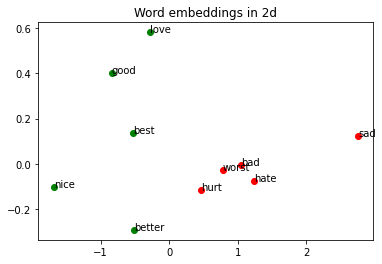

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

#Selection of negative and positive words
neg_words = ['worst', 'bad', 'hurt', 'sad', 'hate']
pos_words = ['best', 'good', 'nice', 'better', 'love']

#Index of each selected word
neg_n = [Vocab[w] for w in neg_words]
pos_n = [Vocab[w] for w in pos_words]

plt.figure()

#Scatter plot for negative words
plt.scatter(emb_2dim[neg_n][:,0],emb_2dim[neg_n][:,1], color = 'r')
for i, txt in enumerate(neg_words): 
    plt.annotate(txt, (emb_2dim[neg_n][i,0],emb_2dim[neg_n][i,1]))

#Scatter plot for positive words
plt.scatter(emb_2dim[pos_n][:,0],emb_2dim[pos_n][:,1], color = 'g')
for i, txt in enumerate(pos_words): 
    plt.annotate(txt,(emb_2dim[pos_n][i,0],emb_2dim[pos_n][i,1]))

plt.title('Word embeddings in 2d')

plt.show()